# START HERE

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from torchvision.transforms import ToTensor
class CustomDataset(Dataset):
    def __init__(self, image_file, label_file, transform=None):
        self.images = np.load(image_file)
        # self.images = (self.images - np.mean(self.images)) / np.std(self.images)
        self.labels = np.load(label_file)
        self.transform = transform
        # self.max_value = np.amax(self.images)
        # self.min_value = np.amin(self.images)

    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Apply the transformation
        if self.transform:
          # Apply random cropping to both the image and the mask
          seed = np.random.randint(2147483647)
          random.seed(seed)
          image = Image.fromarray(image)
          image = self.transform(image)

          random.seed(seed)
          label = Image.fromarray(label)
          label = self.transform(label)

          # Convert images and masks back to NumPy arrays
          image = np.array(label)
          label = np.array(label)

        # # Convert image and label to torch tensors
        # image = (image - self.min_value) / (self.max_value - self.min_value)
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).long()

        return image, label

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CombinedFocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, gamma=2, beta=0.3, eps=1e-7, focal_weight=0.5):
        super(CombinedFocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.eps = eps
        self.focal_weight = focal_weight
        self.tversky_weight = 1 - focal_weight

    def focal_loss(self, y_pred, y_true):
        bce = F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='none')
        p_t = torch.exp(-bce)
        focal_loss = self.alpha * (1 - p_t)**self.gamma * bce
        return focal_loss.mean()

    def tversky_loss(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        tp = (y_pred * y_true).sum()
        fp = ((1 - y_true) * y_pred).sum()
        fn = (y_true * (1 - y_pred)).sum()
        tversky_index = (tp + self.eps) / (tp + self.beta * fn + (1 - self.beta) * fp + self.eps)
        tversky_loss = 1 - tversky_index
        return tversky_loss

    def forward(self, y_pred, y_true):
        focal = self.focal_loss(y_pred, y_true)
        tversky = self.tversky_loss(y_pred, y_true)
        combined_loss = self.focal_weight * focal + self.tversky_weight * tversky
        return combined_loss

In [ ]:
criterion = CombinedFocalTverskyLoss(alpha=0.75, gamma=4, beta=0.2, focal_weight=0.33)
# criterion = CombinedFocalDiceLoss(alpha=0.89, gamma=4, lambda_focal=1)
# criterion = CombinedFocalDiceLoss(alpha=0.89, gamma=4, lambda_focal=0)
# criterion = CombinedFocalDiceLoss(alpha=0.89, gamma=4, lambda_focal=0.5)
# criterion = CombinedFocalDiceLoss(alpha=0.89, gamma=4, lambda_focal=0.25)
# criterion = CombinedFocalDiceLoss(alpha=0.89, gamma=4, lambda_focal=0.73)

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class CombinedFocalDiceLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2, eps=1e-7, lambda_focal=0.7):
#         super(CombinedFocalDiceLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.eps = eps
#         self.lambda_focal = lambda_focal

#     def focal_loss(self, y_pred, y_true):
#         bce = F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='none')
#         p_t = torch.exp(-bce)
#         focal_loss = self.alpha * (1 - p_t)**self.gamma * bce
#         return focal_loss.mean()

#     def dice_loss(self, y_pred, y_true):
#         y_pred = torch.sigmoid(y_pred)
#         y_pred = y_pred.view(-1)
#         y_true = y_true.view(-1)
#         intersection = (y_pred * y_true).sum()
#         dice_loss = 1 - (2 * intersection + self.eps) / (y_pred.sum() + y_true.sum() + self.eps)
#         return dice_loss

#     def forward(self, y_pred, y_true):
#         focal = self.focal_loss(y_pred, y_true)
#         dice = self.dice_loss(y_pred, y_true)
#         combined_loss = self.lambda_focal * focal + (1 - self.lambda_focal) * dice
#         return combined_loss

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class CombinedLoss(nn.Module):
#     def __init__(self, alpha=0.5):
#         super(CombinedLoss, self).__init__()
#         self.alpha = alpha
#         self.bce_loss = nn.BCEWithLogitsLoss()

#     def dice_loss(self, pred, target):
#         smooth = 1e-7
#         pred = torch.sigmoid(pred)
#         intersection = (pred * target).sum(dim=(2, 3))
#         union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
#         dice = (2 * intersection + smooth) / (union + smooth)
#         return (1 - dice).mean()

#     def forward(self, pred, target):
#         bce = self.bce_loss(pred, target)
#         dice = self.dice_loss(pred, target)
#         return self.alpha * bce + (1 - self.alpha) * dice

# criterion = CombinedLoss(alpha=0.37)

### ResNet50 + ViT

In [ ]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import timm
import torch.nn.functional as F

torch.cuda.empty_cache()
class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        # ResNet50
        self.resnet50 = models.resnet50(pretrained=True)

        # ResNet50 encoder layers
        self.encoder1 = nn.Sequential(*list(self.resnet50.children())[:5])
        self.encoder2 = list(self.resnet50.children())[5]
        self.encoder3 = list(self.resnet50.children())[6]
        self.encoder4 = list(self.resnet50.children())[7]

        # Vision Transformer
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0, drop_rate=0.1)

        # Decoder layers
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(2816, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(2048, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(512, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, num_classes, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

        self.batch_norm = nn.BatchNorm2d(num_classes)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        vit_features = self.vit(x_resized)

        vit_features = vit_features.unsqueeze(-1).unsqueeze(-1)
        vit_features = F.interpolate(vit_features, size=e4.shape[2:], mode='nearest')

        combined_features = torch.cat([e4, vit_features], dim=1)

        d4 = self.decoder4(combined_features)
        d4_adapt = F.adaptive_avg_pool2d(d4, e3.size()[2:])
        d3 = self.decoder3(torch.cat([d4_adapt, e3], dim=1))
        d3_adapt = F.adaptive_avg_pool2d(d3, e2.size()[2:])
        d2 = self.decoder2(torch.cat([d3_adapt, e2], dim=1))
        d2_adapt = F.adaptive_avg_pool2d(d2, e1.size()[2:])
        d1 = self.decoder1(torch.cat([d2_adapt, e1], dim=1))

        output = F.interpolate(d1, size=x.shape[2:], mode='bilinear', align_corners=False)
        out = self.batch_norm(output)
        return out

num_classes = 3
model = CombinedModel(num_classes).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 313MB/s]


In [ ]:
# Load the saved model state
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/Focal_loss_ViT_ResNet50_FCN_seg_model.pt'))
model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/resnet50_vit/Combined_loss_ResNet50_vit_model.pt'))

<All keys matched successfully>

In [ ]:
# from torchsummary import summary
# print(summary(model, (3, 300, 310)))

In [ ]:
input_tensor = torch.randn(1, 3, 310, 360).to(device)
# Forward pass through the model
output = model(input_tensor)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 3, 310, 360])


## Train

In [ ]:
# crop_size = (224, 224)
# train_transform = transforms.Compose([
#     transforms.RandomCrop(crop_size),
# ])

In [ ]:
image_paths = '/content/drive/MyDrive/EECS545 Final Project/new_data/train_data_2.npy'
label_paths = '/content/drive/MyDrive/EECS545 Final Project/new_data/train_labels_2.npy'
train_dataset = CustomDataset(image_paths, label_paths, transform=None)

In [ ]:
val_input_path = '/content/drive/MyDrive/EECS545 Final Project/new_data/val_data.npy'
val_labels_path = '/content/drive/MyDrive/EECS545 Final Project/new_data/val_labels.npy'
val_dataset = CustomDataset(val_input_path,val_labels_path, transform=None)
val_loader = DataLoader(val_dataset, batch_size=88, shuffle=True, num_workers=0)

### Start Training

In [ ]:
# bs = 118 # standard freeze pretrain
# bs = 42 # standard train all
# bs = 280
# 288 # Premium freeze pretrain
bs = 42 # Premium train all
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.79, 0.89))
#
print(bs)
print("{:.7f}".format(optimizer.param_groups[0]['lr']))

42
0.0100000


In [ ]:
for param in model.resnet50.parameters():
  param.requires_grad = True
for param in model.vit.parameters():
  param.requires_grad = True

In [ ]:
num_epochs = 5
train_loss = 0
for epoch in range(num_epochs):
  model.train()
  train_loss = 0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    labels = labels.float()
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  train_loss /= len(train_loader)
  print(f'Epoch: {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}')

print("Training finished.")
print(train_loss)

Epoch: 1/5, Train Loss: 0.2434
Epoch: 2/5, Train Loss: 0.2286
Epoch: 3/5, Train Loss: 0.2121
Epoch: 4/5, Train Loss: 0.1906
Epoch: 5/5, Train Loss: 0.1645
Training finished.
0.16449245968551346


In [ ]:
model.eval()
val_error = 0
total_samples = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float()  # Convert the target tensor to float

        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Update test error and total samples
        val_error += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

# Calculate the average test error
avg_val_error = val_error / total_samples
print("Average Val Error: {:.4f}".format(avg_val_error))

Average Val Error: 0.3622


(3, 310, 360)


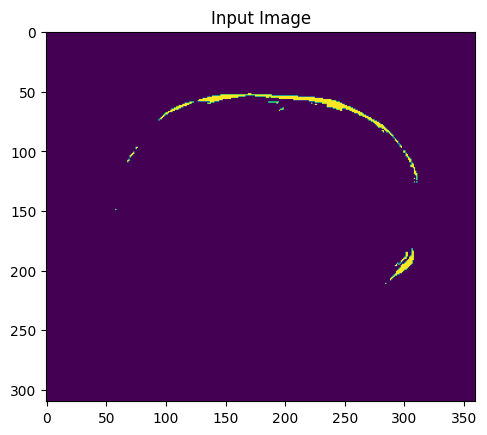

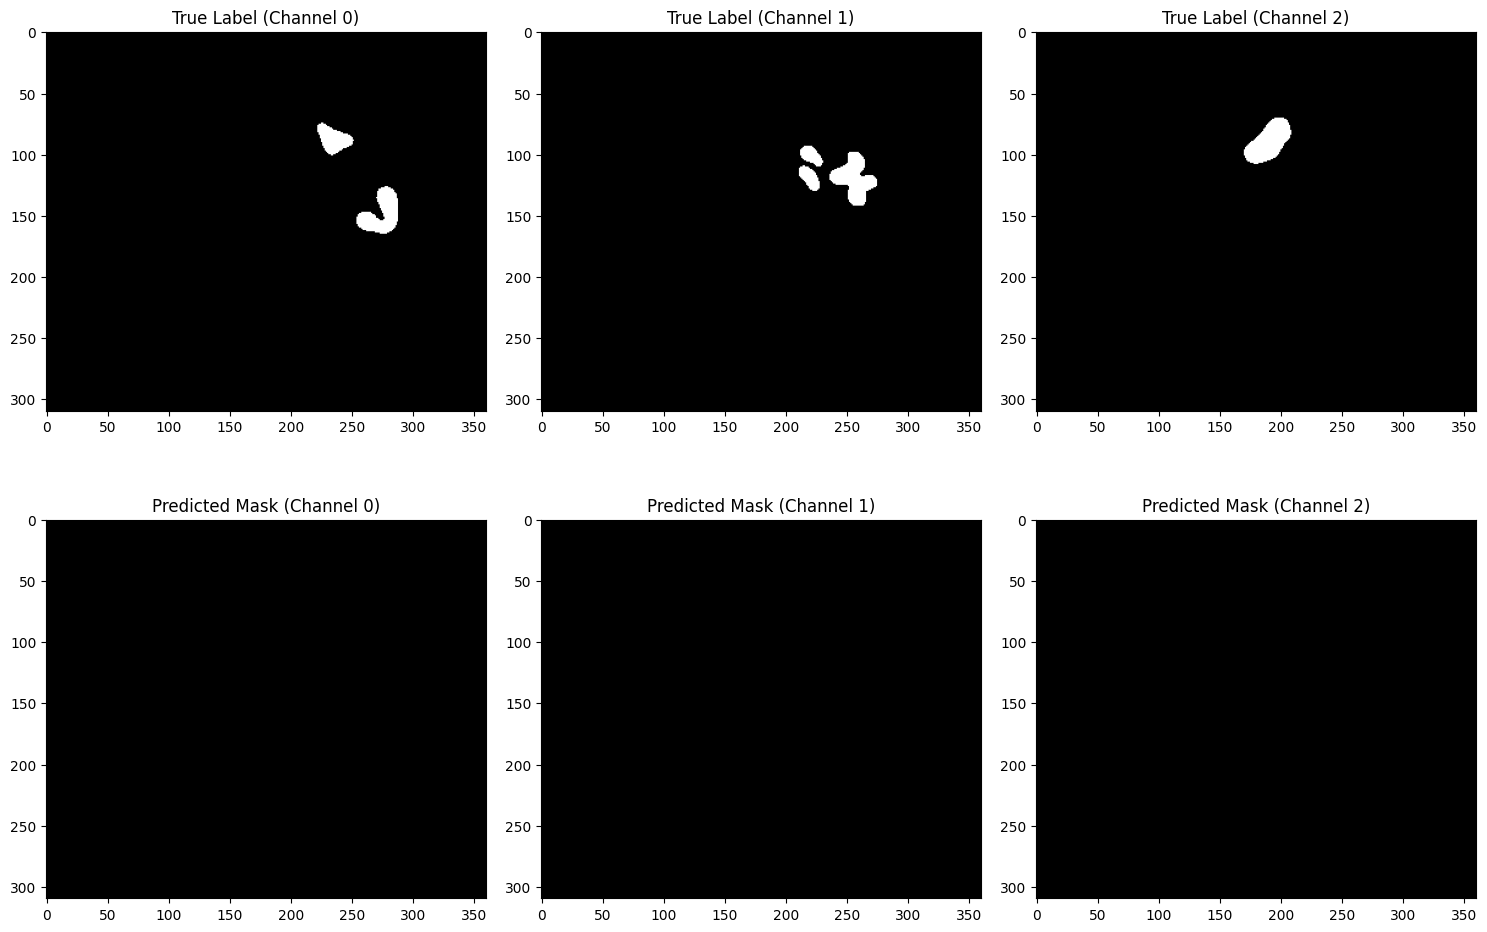

In [ ]:
import matplotlib.pyplot as plt
input_image = np.load("/content/drive/MyDrive/EECS545 Final Project/new_data/sample_input1.npy")
true_label_image = np.load("/content/drive/MyDrive/EECS545 Final Project/new_data/sample_label1.npy")
input_image = torch.from_numpy(input_image).to(device)
input_image = input_image.view(1,3,310,360)
input_image = input_image.to(torch.float32)
outputs = model(input_image)
probs = torch.sigmoid(outputs)
predicted_labels = (probs > 0.5).float()

input_image = input_image.cpu().squeeze().numpy()
print(input_image.shape)
plt.imshow(input_image[1,:,:])
plt.title("Input Image")
plt.show()

# Move the true_label and pred_mask back to the CPU and remove the batch dimension
true_label = true_label_image.squeeze()
pred_mask = predicted_labels.squeeze().cpu().numpy()

fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i in range(3):
    ax[0, i].imshow(true_label[i,:,:], cmap='gray')
    ax[0, i].set_title(f"True Label (Channel {i})")

    ax[1, i].imshow(pred_mask[i,:,:], cmap='gray')
    ax[1, i].set_title(f"Predicted Mask (Channel {i})")

plt.savefig("/content/drive/MyDrive/EECS545 Final Project/resnet50/Figure_0epoch.png")
plt.tight_layout()
plt.show()

np.save("/content/drive/MyDrive/EECS545 Final Project/resnet50_vit/mask_0epoch.npy", pred_mask)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/resnet50_vit/Combined_loss_ResNet50_vit_model.pt')

## Test

In [ ]:
# Load test dataset
test_data_path = '/content/drive/MyDrive/EECS545 Final Project/new_data/test_data.npy'
test_labels_path = '/content/drive/MyDrive/EECS545 Final Project/new_data/test_labels.npy'
# Create a CustomDataset for test data
test_dataset = CustomDataset(test_data_path, test_labels_path, transform=None)

In [ ]:
# Overall Test error
batch_size = 88
# Create a DataLoader for test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Switch the model to evaluation mode
model.eval()

# Initialize test error and total number of test samples
test_error = 0
total_samples = 0

# Iterate through the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float()  # Convert the target tensor to float

        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Update test error and total samples
        test_error += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

# Calculate the average test error
avg_test_error = test_error / total_samples
print("Average Test Error: {:.4f}".format(avg_test_error))

Average Test Error: 0.1258
